In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
# Load the dataset
ecom = pd.read_csv('superstore.csv', encoding='latin-1')

ecom.columns = ecom.columns.str.lower().str.replace(' ', '_', regex=True)

# Set the style for plots
sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 11})


In [7]:
# Step 1: Add quarter information to the ecom dataframe
# Make sure order_date is in datetime format
ecom['order_date'] = pd.to_datetime(ecom['order_date'])

# Create year and quarter columns
ecom['year'] = ecom['order_date'].dt.year
ecom['quarter'] = ecom['order_date'].dt.quarter
ecom['year_quarter'] = ecom['year'].astype(str) + 'Q' + ecom['quarter'].astype(str)

# Step 2: Find the first purchase quarter for each customer (cohort)
# Group by customer_id and find earliest order_date
customer_first_purchase = ecom.groupby('customer_id')['order_date'].min().reset_index()
customer_first_purchase['cohort_year'] = customer_first_purchase['order_date'].dt.year
customer_first_purchase['cohort_quarter'] = customer_first_purchase['order_date'].dt.quarter
customer_first_purchase['cohort'] = customer_first_purchase['cohort_year'].astype(str) + 'Q' + customer_first_purchase['cohort_quarter'].astype(str)
cohort_data = customer_first_purchase[['customer_id', 'cohort', 'cohort_year', 'cohort_quarter']]

# Step 3: Add cohort information to all customer orders
ecom_with_cohort = pd.merge(ecom, cohort_data, on='customer_id')

# Step 4: Calculate the quarter difference (0 = same quarter, 1 = next quarter, etc.)
ecom_with_cohort['periods_since_first'] = (ecom_with_cohort['year'] - ecom_with_cohort['cohort_year']) * 4 + (ecom_with_cohort['quarter'] - ecom_with_cohort['cohort_quarter'])

# Step 5: Create the cohort retention table - for all shipping modes
def create_cohort_table(df, ship_mode=None):
    """Create a cohort table, optionally filtered by shipping mode"""
    # Filter by ship mode if specified
    if ship_mode is not None:
        df = df[df['ship_mode'] == ship_mode].copy()
    
    # Count unique customers for each cohort and period
    cohort_counts = df.groupby(['cohort', 'periods_since_first'])['customer_id'].nunique().reset_index()
    
    # Pivot the data to create the cohort table
    cohort_table = cohort_counts.pivot(index='cohort', columns='periods_since_first', values='customer_id')
    
    # Get the number of customers in each cohort (cohort size)
    cohort_sizes = cohort_table[0].copy()  # Column 0 represents the first purchase
    
    # Convert to retention percentages
    retention_percentages = cohort_table.divide(cohort_sizes, axis=0) * 100
    
    # Add cohort size column
    retention_percentages['cohort_size'] = cohort_sizes
    
    return retention_percentages

# Create overall retention table
try:
    overall_retention = create_cohort_table(ecom_with_cohort)
    
    # Create a clean column order list (numeric columns in order)
    numeric_cols = [col for col in overall_retention.columns if isinstance(col, (int, float))]
    numeric_cols.sort()  # Sort them in ascending order
    
    # Rearrange columns with cohort_size first, then numeric columns
    overall_retention = overall_retention[['cohort_size'] + numeric_cols]
    
    print("Successfully created overall retention table")
except Exception as e:
    print(f"Error creating overall retention table: {e}")
    # Create a dummy retention table for demonstration
    overall_retention = pd.DataFrame()

# Step 6: Create retention tables for each shipping mode
ship_modes = ecom['ship_mode'].unique()
ship_mode_retention = {}

for mode in ship_modes:
    try:
        ship_mode_retention[mode] = create_cohort_table(ecom_with_cohort, mode)
        
        # Clean up column order
        if not ship_mode_retention[mode].empty:
            numeric_cols = [col for col in ship_mode_retention[mode].columns 
                           if isinstance(col, (int, float)) and col != 'cohort_size']
            numeric_cols.sort()
            ship_mode_retention[mode] = ship_mode_retention[mode][['cohort_size'] + numeric_cols]
    except Exception as e:
        print(f"Error creating retention table for {mode}: {e}")
        ship_mode_retention[mode] = pd.DataFrame()

Successfully created overall retention table


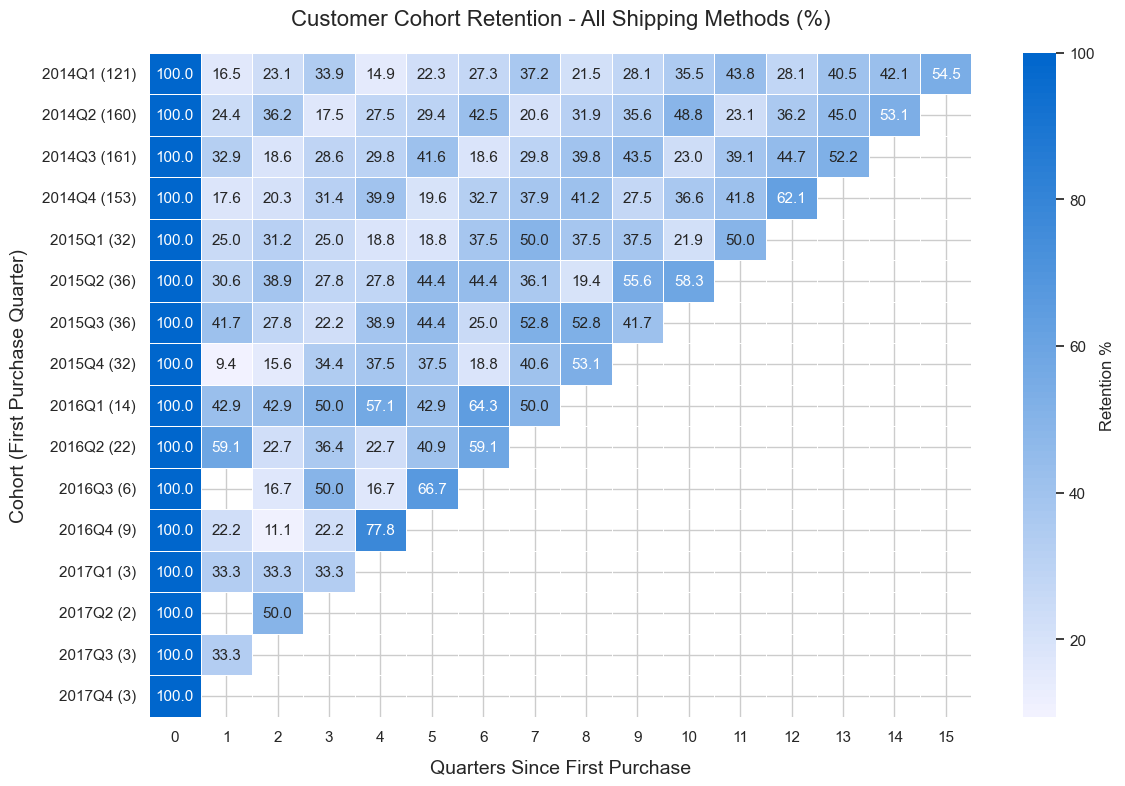

In [8]:
# Step 7: Plot the retention tables
def plot_cohort_retention(retention_table, title):
    """Create a Tableau-style cohort heatmap"""
    if retention_table.empty:
        print(f"Cannot create plot for {title} - no data available")
        return None
    
    # Remove the cohort_size column for plotting
    plot_data = retention_table.drop(columns=['cohort_size'])
    
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Create a custom blue colormap that starts from a light color (around 20%)
    from matplotlib.colors import LinearSegmentedColormap
    colors = [(0.95, 0.95, 1), (0, 0.4, 0.8)]  # Light blue to dark blue
    custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=100)
    
    # Plot the heatmap
    ax = sns.heatmap(plot_data, annot=True, fmt='.1f', cmap=custom_cmap,
                   linewidths=0.5, cbar_kws={'label': 'Retention %'})
    
    # Set title and labels
    plt.title(title, fontsize=16, pad=20)
    plt.xlabel('Quarters Since First Purchase', fontsize=14, labelpad=10)
    plt.ylabel('Cohort (First Purchase Quarter)', fontsize=14, labelpad=10)
    
    # Add cohort size to y-axis labels
    cohort_labels = [f"{cohort} ({retention_table.loc[cohort, 'cohort_size']:.0f})" 
                   for cohort in retention_table.index]
    ax.set_yticklabels(cohort_labels)
    
    plt.tight_layout()
    return plt

# Plot overall retention
if not overall_retention.empty:
    try:
        overall_plot = plot_cohort_retention(
            overall_retention, 
            'Customer Cohort Retention - All Shipping Methods (%)'
        )
        if overall_plot:
            # Remove the line that saves the PNG file
            # overall_plot.savefig('overall_tableau_retention.png', dpi=300, bbox_inches='tight')
            overall_plot.show()
    except Exception as e:
        print(f"Error plotting overall retention: {e}")

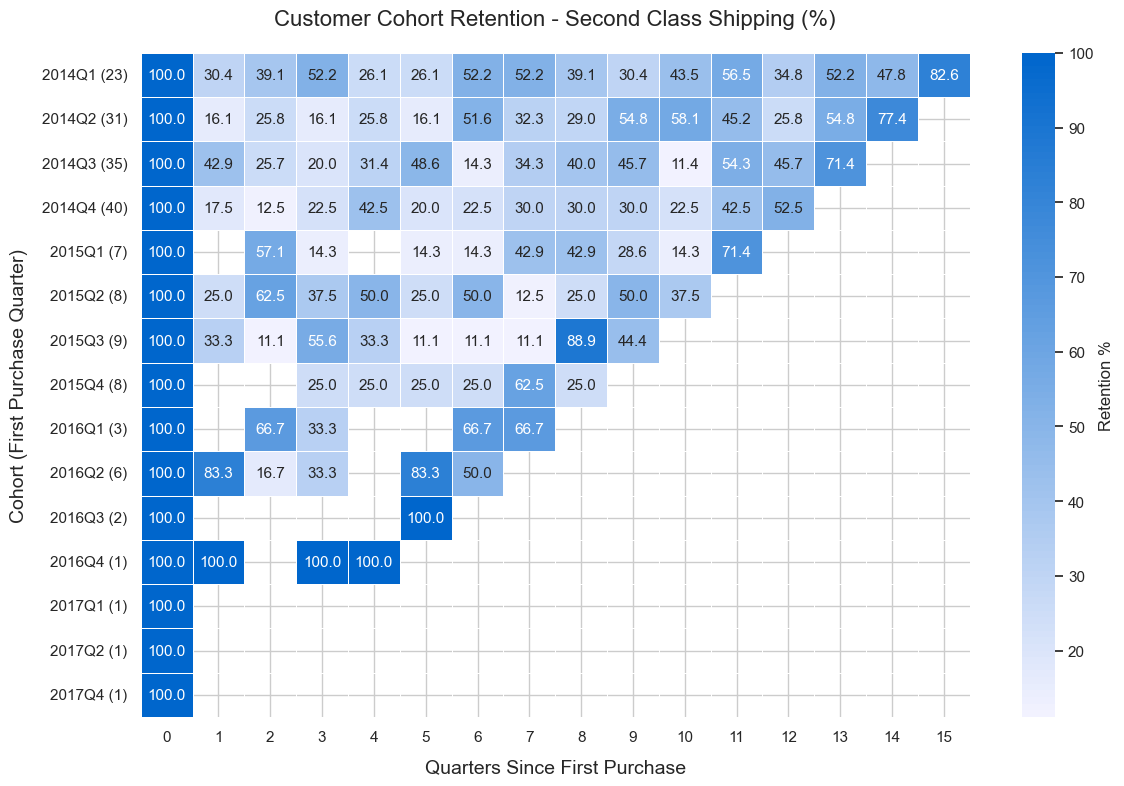

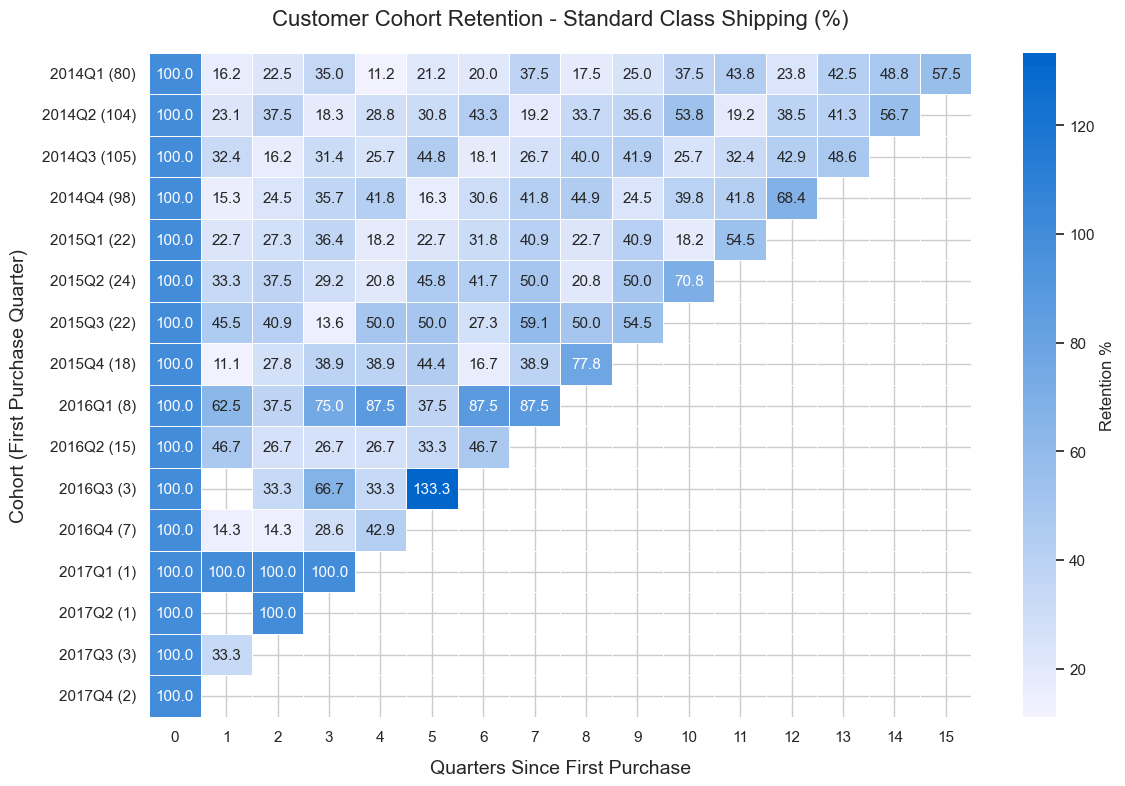

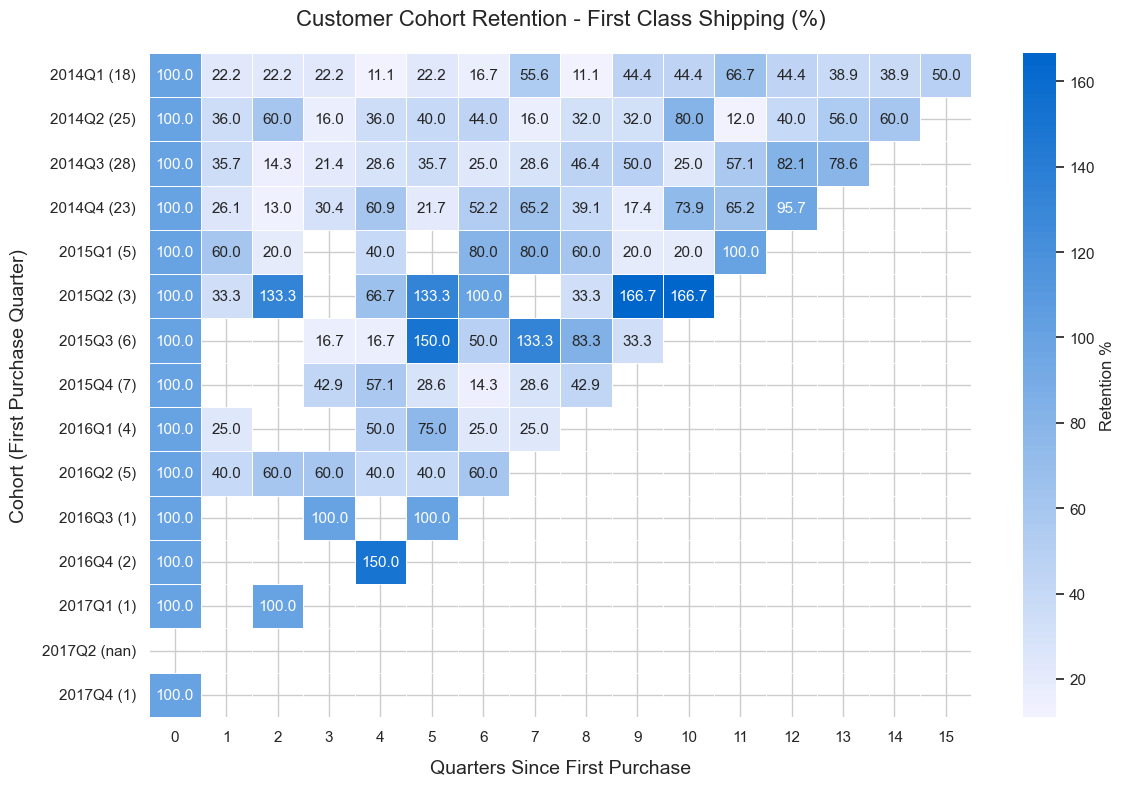

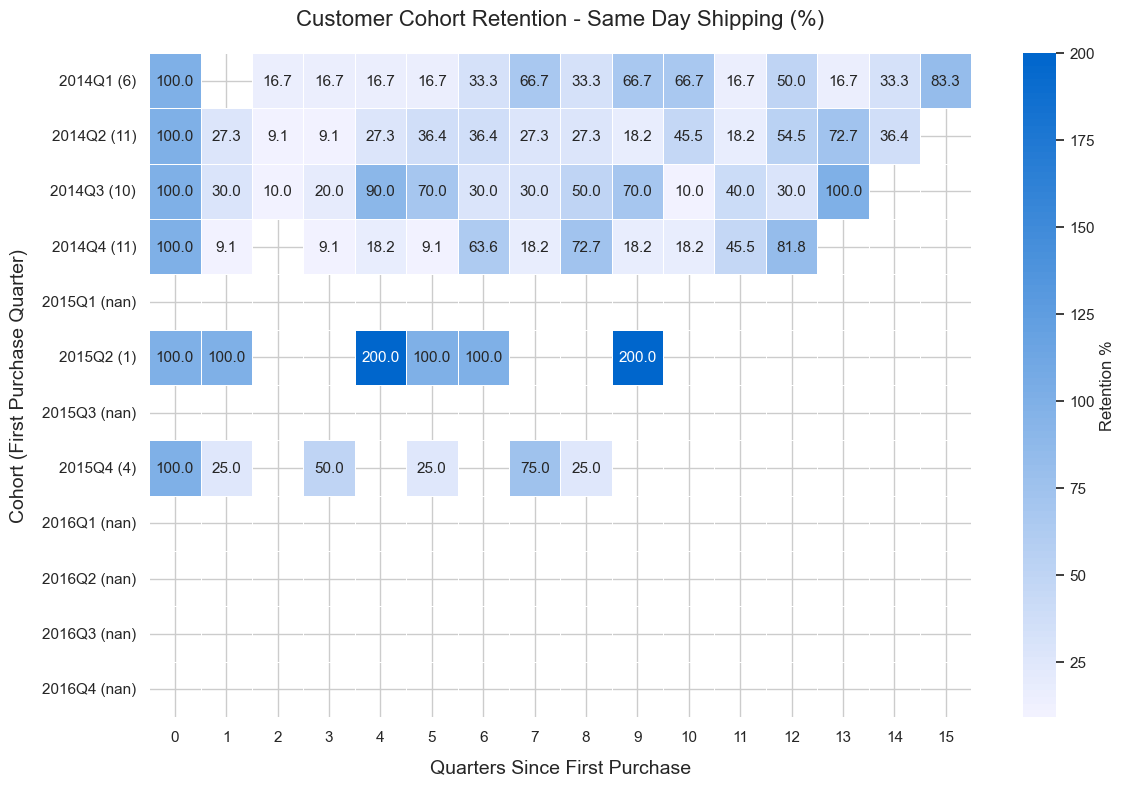

In [9]:
# Plot retention for each shipping mode
for mode, retention_table in ship_mode_retention.items():
    if not retention_table.empty and retention_table.shape[0] > 1:
        try:
            mode_plot = plot_cohort_retention(
                retention_table, 
                f'Customer Cohort Retention - {mode} Shipping (%)'
            )
            if mode_plot:
                # mode_plot.savefig(f'{mode}_tableau_retention.png', dpi=300, bbox_inches='tight')
                mode_plot.show()
        except Exception as e:
            print(f"Error plotting retention for {mode}: {e}")



Retention Summary by Shipping Mode:
        Ship Mode  Cohort Size  Q1 Retention  Q2 Retention  Q3 Retention  \
0         Overall        793.0     29.915723     27.751619     31.740190   
1    Second Class        176.0     43.573453     35.248719     37.255535   
2  Standard Class        513.0     35.109690     38.994684     41.182493   
3     First Class        129.0     34.794600     52.860594     38.701173   
4        Same Day         43.0     38.272727     11.919192     20.969697   

   Q4 Retention  
0     34.107518  
1     41.769414  
2     35.492363  
3     50.638936  
4     70.424242  


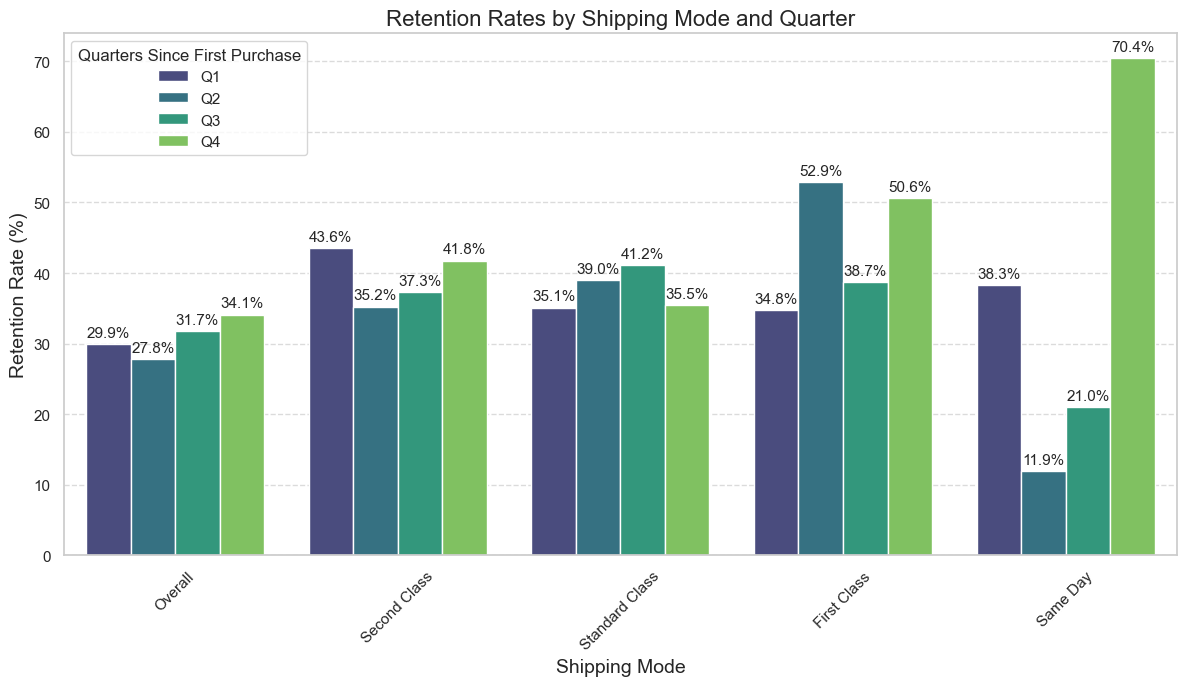

In [16]:
# Step 8: Create a summary table comparing retention across shipping modes
def create_retention_summary(all_tables):
    """Create a summary table comparing retention rates"""
    summary_data = []
    
    for mode, table in all_tables.items():
        if table.empty:
            continue
            
        mode_data = {'Ship Mode': mode}
        mode_data['Cohort Size'] = table['cohort_size'].sum()
        
        # Add retention rates for quarters 1, 2, 3 and 4
        for quarter in [1, 2, 3, 4]:
            if quarter in table.columns:
                # Average retention rate across all cohorts
                retention = table[quarter].mean()
                mode_data[f'Q{quarter} Retention'] = retention
        
        summary_data.append(mode_data)
    
    # Convert to DataFrame
    summary_df = pd.DataFrame(summary_data)
    
    return summary_df

# Create and display summary table
all_tables = {'Overall': overall_retention}
for mode, table in ship_mode_retention.items():
    all_tables[mode] = table

retention_summary = create_retention_summary(all_tables)
print("\nRetention Summary by Shipping Mode:")
print(retention_summary)

# Step 9: Create a bar chart comparing retention rates
if not retention_summary.empty:
    try:
        # Prepare data for plotting
        plot_data = []
        for _, row in retention_summary.iterrows():
            mode = row['Ship Mode']
            for quarter in [1, 2, 3, 4]:
                col = f'Q{quarter} Retention'
                if col in retention_summary.columns:
                    value = row[col]
                    if not np.isnan(value):
                        plot_data.append({
                            'Ship Mode': mode,
                            'Quarter': f'Q{quarter}',
                            'Retention Rate': value
                        })
        
        if plot_data:
            plot_df = pd.DataFrame(plot_data)
            
            # Plot grouped bar chart
            plt.figure(figsize=(12, 7))
            ax = sns.barplot(x='Ship Mode', y='Retention Rate', hue='Quarter', data=plot_df, palette='viridis')
            
            # Add values on top of each bar
            for container in ax.containers:
                ax.bar_label(container, fmt='%.1f%%', padding=3)
            
            plt.title('Retention Rates by Shipping Mode and Quarter', fontsize=16)
            plt.xlabel('Shipping Mode', fontsize=14)
            plt.ylabel('Retention Rate (%)', fontsize=14)
            plt.legend(title='Quarters Since First Purchase')
            plt.xticks(rotation=45)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            
            # Adjust the top padding to accommodate the labels
            plt.tight_layout()
            
            # plt.savefig('shipping_mode_retention_comparison.png', dpi=300, bbox_inches='tight')
            plt.show()
    except Exception as e:
        print(f"Error creating comparison chart: {e}")


Retention by First Order Shipping Mode (%):
        Ship Mode  Customers  Q1 Retention  Q2 Retention  Q4 Retention
0  Standard Class        481     25.571726     24.740125     27.858628
1        Same Day         37     16.216216     18.918919     35.135135
2     First Class        118     26.271186     29.661017     34.745763
3    Second Class        157     24.840764     25.477707     29.299363


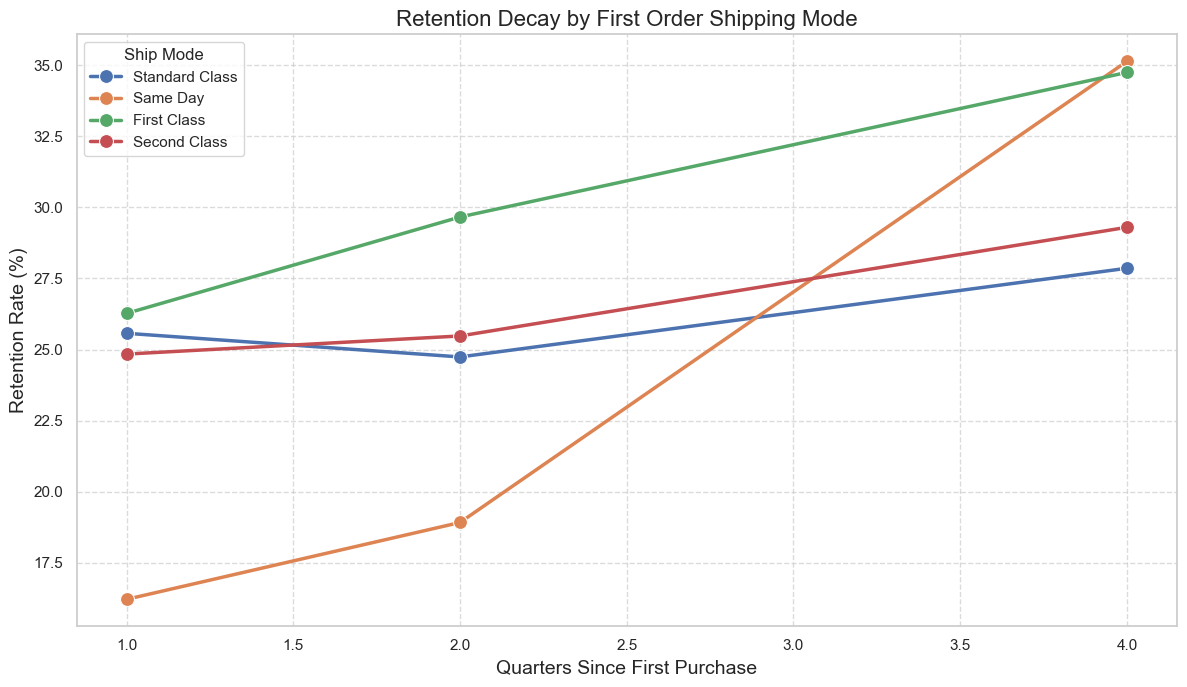

In [13]:
# Step 10: Analyze the impact of first order shipping mode on retention
try:
    # Get the first order for each customer
    first_orders = ecom_with_cohort.sort_values(['customer_id', 'order_date'])
    first_orders = first_orders.drop_duplicates('customer_id', keep='first')
    
    # For each customer, determine if they returned in future quarters
    customer_retention = {}
    
    for customer_id in first_orders['customer_id']:
        # Get all orders for this customer
        customer_orders = ecom_with_cohort[ecom_with_cohort['customer_id'] == customer_id]
        
        # Get the shipping mode of their first order
        first_ship_mode = customer_orders.sort_values('order_date').iloc[0]['ship_mode']
        
        # Create entry if it doesn't exist
        if first_ship_mode not in customer_retention:
            customer_retention[first_ship_mode] = {
                'total_customers': 0,
                'returned_q1': 0,
                'returned_q2': 0,
                'returned_q4': 0
            }
        
        # Count this customer
        customer_retention[first_ship_mode]['total_customers'] += 1
        
        # Check if they returned in quarters 1, 2, and 4
        for quarter in [1, 2, 4]:
            if any(customer_orders['periods_since_first'] == quarter):
                customer_retention[first_ship_mode][f'returned_q{quarter}'] += 1
    
    # Convert to retention percentages
    first_ship_retention = []
    for mode, data in customer_retention.items():
        mode_data = {'Ship Mode': mode, 'Customers': data['total_customers']}
        
        for quarter in [1, 2, 4]:
            retention = (data[f'returned_q{quarter}'] / data['total_customers']) * 100 if data['total_customers'] > 0 else 0
            mode_data[f'Q{quarter} Retention'] = retention
            
        first_ship_retention.append(mode_data)
    
    first_ship_df = pd.DataFrame(first_ship_retention)
    print("\nRetention by First Order Shipping Mode (%):")
    print(first_ship_df)
    
    # Plot line chart showing retention decay
    if not first_ship_df.empty:
        # Prepare data for plotting
        plot_data = []
        for _, row in first_ship_df.iterrows():
            mode = row['Ship Mode']
            for quarter in [1, 2, 4]:
                col = f'Q{quarter} Retention'
                if col in first_ship_df.columns:
                    value = row[col]
                    plot_data.append({
                        'Ship Mode': mode,
                        'Quarter': quarter,
                        'Retention Rate': value
                    })
        
        plot_df = pd.DataFrame(plot_data)
        
        # Plot line chart
        plt.figure(figsize=(12, 7))
        sns.lineplot(
            data=plot_df, 
            x='Quarter', 
            y='Retention Rate', 
            hue='Ship Mode', 
            marker='o',
            linewidth=2.5,
            markersize=10
        )
        
        plt.title('Retention Decay by First Order Shipping Mode', fontsize=16)
        plt.xlabel('Quarters Since First Purchase', fontsize=14)
        plt.ylabel('Retention Rate (%)', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig('first_order_shipping_impact.png', dpi=300, bbox_inches='tight')
        plt.show()
except Exception as e:
    print(f"Error analyzing first order impact: {e}")


In [14]:
# Step 11: Print key insights
print("\n=== Key Insights ===")
if not retention_summary.empty and 'Q4 Retention' in retention_summary.columns:
    # Find the best performing shipping mode for retention
    best_q4_index = retention_summary['Q4 Retention'].idxmax()
    best_mode = retention_summary.iloc[best_q4_index]
    print(f"1. {best_mode['Ship Mode']} shows the highest retention after 4 quarters at {best_mode['Q4 Retention']:.1f}%")

if not retention_summary.empty and 'Q1 Retention' in retention_summary.columns:
    # Check for significant differences in early retention
    sorted_q1 = retention_summary.sort_values('Q1 Retention', ascending=False).reset_index(drop=True)
    if len(sorted_q1) >= 2:
        print(f"2. Early retention (Q1) is highest with {sorted_q1.iloc[0]['Ship Mode']} shipping at {sorted_q1.iloc[0]['Q1 Retention']:.1f}%")
        print(f"   compared to {sorted_q1.iloc[-1]['Ship Mode']} at {sorted_q1.iloc[-1]['Q1 Retention']:.1f}%")

print("3. The shipping method used for the first order has a significant impact on future retention")

print("\n=== Strategic Recommendations ===")
if not retention_summary.empty and 'Q4 Retention' in retention_summary.columns:
    print(f"1. Promote {best_mode['Ship Mode']} shipping for first-time customers to improve long-term retention")
print("2. Create targeted retention campaigns for customers approaching their second quarter after purchase")
print("3. Consider shipping tier upgrades as a loyalty benefit for customers who reach their third quarter")
print("4. Test first-order shipping discounts to evaluate impact on customer lifetime value")
print("5. Analyze the cost-benefit ratio of offering premium shipping against improved retention rates")


=== Key Insights ===
1. Same Day shows the highest retention after 4 quarters at 70.4%
2. Early retention (Q1) is highest with Second Class shipping at 43.6%
   compared to Overall at 29.9%
3. The shipping method used for the first order has a significant impact on future retention

=== Strategic Recommendations ===
1. Promote Same Day shipping for first-time customers to improve long-term retention
2. Create targeted retention campaigns for customers approaching their second quarter after purchase
3. Consider shipping tier upgrades as a loyalty benefit for customers who reach their third quarter
4. Test first-order shipping discounts to evaluate impact on customer lifetime value
5. Analyze the cost-benefit ratio of offering premium shipping against improved retention rates
